In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from compute_Final import compute_F
from scipy.optimize import minimize


Load dataset

In [2]:
f = np.loadtxt('terminal_feed_fraction_f.csv', delimiter=',', skiprows=1)
F = np.loadtxt('terminal_incorporated_fraction_F.csv', delimiter=',', skiprows=1)

Train-test split

In [3]:
f_train, f_test, F_train, F_test \
    = train_test_split(f, F, test_size=0.1)
print('Split into {} train and {} test samples'.format(
    f_train.shape[0], f_test.shape[0]))

Split into 80 train and 9 test samples


Define loss function
$$
    \mathrm{Loss}(K)
    =
    \left\|
        F - \frac{ f \circ {K}^T v_0(K, f) }{ f^T {K}^T v_0(K, f)}
    \right\|^2
    +
    \lambda
    (K_{11} -1)^2
$$
Here I just take $\lambda=100$ (the value doesn't matter as long as it's big
enough, as long as the regressed $K_{11}$ is close to 1, it's fine).

In [4]:
def loss(K_flat, *args):
    f_batch, F_batch = args
    n = np.sqrt(K_flat.size).astype('int')
    K = K_flat.reshape(n, n)
    l = 0
    for f, F in zip(f_batch, F_batch):
        l += np.linalg.norm(F - compute_F(f, K))**2
    l += 100 * (K_flat[0] - 1.0)**2
    return l

Use lbfgs to find K (any other optimization methods also works)

In [5]:
n = 3
K_init = np.random.uniform(size=(n**2,))  # initial guess - can use any prior knowledge here
bounds = [(1e-6, 10), ]*(n**2)  # the upper bound is rather arbitrary, large enough will do

In [6]:
results = minimize(
    loss, K_init,
    method='L-BFGS-B',
    bounds=bounds, args=(f_train, F_train),
    options={'ftol': 1e-16, 'gtol': 1e-16})
print(results['message'])

K_final = results['x'].reshape(n, n)

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH


Fitted K

In [9]:
print(K_final)

[[1.         1.84362936 1.79391072]
 [0.25086437 0.5096105  1.14396455]
 [0.8561203  1.61089269 0.0683654 ]]


Test the predicted F on the test set using the fitted K

In [10]:
F_pred_test = []

for f in f_test:
    F_pred_test.append(compute_F(f, K_final))

F_pred_test = np.asarray(F_pred_test)

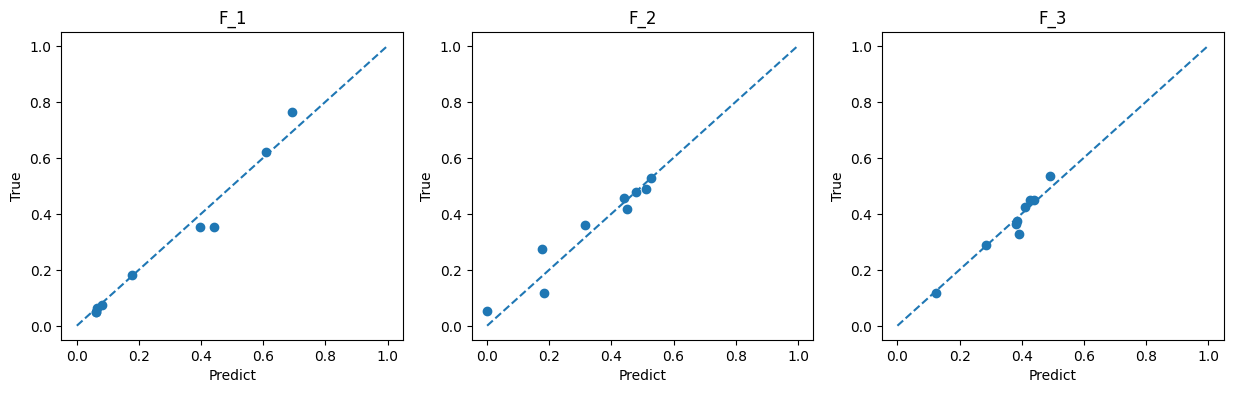

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
for i in range(n):
    ax[i].scatter(F_pred_test[:, i], F_test[:, i])
    ax[i].plot(np.linspace(0, 1, 10), np.linspace(0, 1, 10), '--')
    ax[i].set_xlabel('Predict')
    ax[i].set_ylabel('True')
    ax[i].set_title(f'F_{i+1}')